In [185]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [186]:
def load_data():
    data = pd.read_csv('../Dataset/data.csv')
    return data

In [187]:
data = load_data()
data.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,517544.0,"DK, FI, NO, SE"
1,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,444345.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR..."
2,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,tt0338013,8.3,1105967.0,"AG, AR, BB, BO, BS, BZ, CL, CO, CR, DO, EC, GT..."
3,A History of Violence,movie,"Action, Crime, Drama",2005.0,tt0399146,7.4,259262.0,"AG, AR, BB, BO, BR, BS, BZ, CL, CO, CR, DO, EC..."
4,2001: A Space Odyssey,movie,"Adventure, Sci-Fi",1968.0,tt0062622,8.3,736401.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR..."


In [188]:
# get length of countries for better anlaysis
data['num_countries'] = data['availableCountries'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

#time since release
data['Years Since Release'] = 2024 - data["releaseYear"]

In [189]:
data.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,num_countries,Years Since Release
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,517544.0,"DK, FI, NO, SE",4,27.0
1,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,444345.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR...",34,32.0
2,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,tt0338013,8.3,1105967.0,"AG, AR, BB, BO, BS, BZ, CL, CO, CR, DO, EC, GT...",26,20.0
3,A History of Violence,movie,"Action, Crime, Drama",2005.0,tt0399146,7.4,259262.0,"AG, AR, BB, BO, BR, BS, BZ, CL, CO, CR, DO, EC...",27,19.0
4,2001: A Space Odyssey,movie,"Adventure, Sci-Fi",1968.0,tt0062622,8.3,736401.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR...",38,56.0


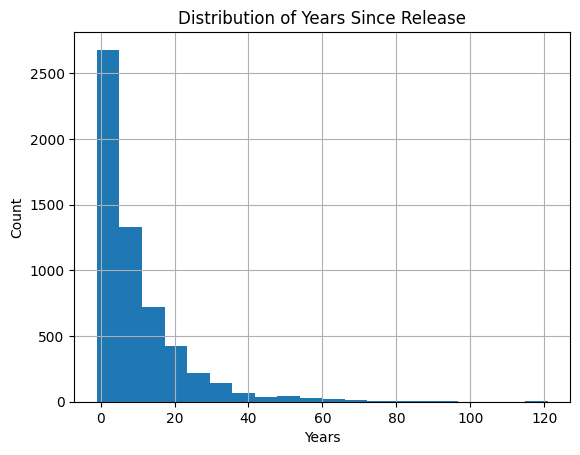

In [190]:
data['Years Since Release'].hist(bins=20)
plt.title('Distribution of Years Since Release')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

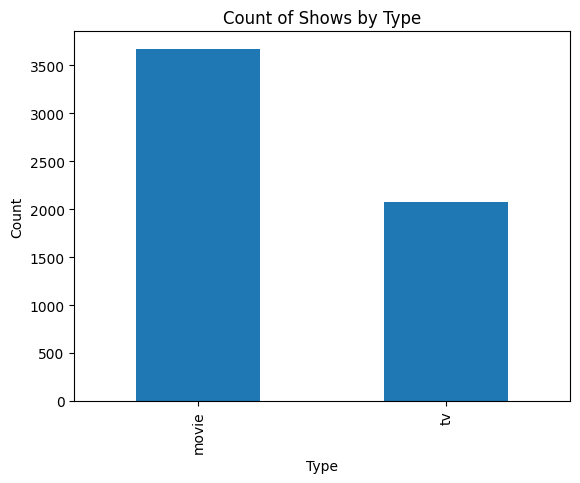

In [191]:
data['type'].value_counts().plot(kind='bar')
plt.title('Count of Shows by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()


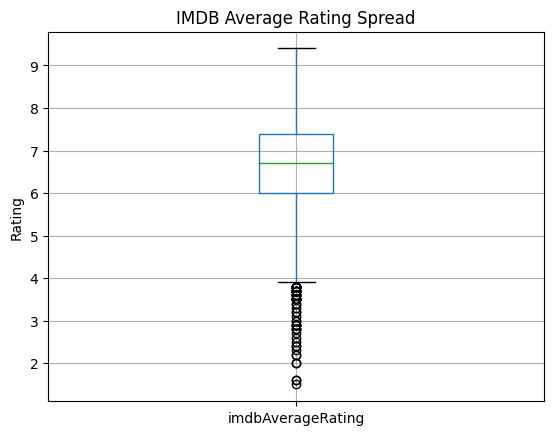

In [192]:
data.boxplot(column='imdbAverageRating')
plt.title('IMDB Average Rating Spread')
plt.ylabel('Rating')
plt.show()

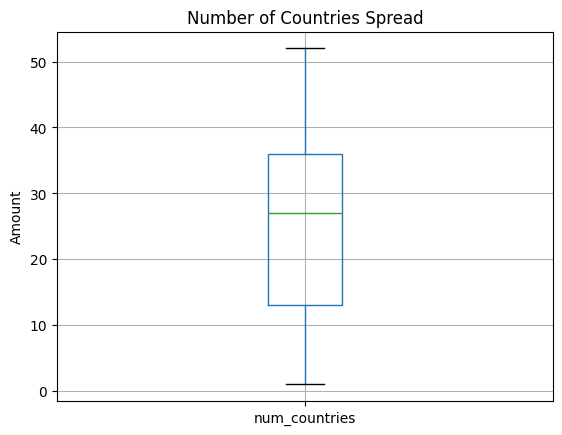

In [193]:
data.boxplot(column='num_countries')
plt.title('Number of Countries Spread')
plt.ylabel('Amount')
plt.show()

In [194]:
#Create threshold for show removal

time_threshold = 17  # Years since release
country_threshold = 26 # Available in fewer than 12 countries
rating_threshold = 6.4

data['retentionDecision'] = np.where(
    (data['Years Since Release'] > time_threshold) | (data['num_countries'] < country_threshold) | (data['imdbAverageRating'] < rating_threshold), 
    1,  # Mark as "Removed Soon"
    0   # Otherwise, not removed soon
)


In [205]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer


# Impute numerical columns with the mean
num_imputer = SimpleImputer(strategy='mean')
numerical_features = ['imdbAverageRating', 'imdbNumVotes', 'releaseYear']
data[numerical_features] = num_imputer.fit_transform(data[numerical_features])

# Impute categorical columns with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
data['type'] = cat_imputer.fit_transform(data[['type']]).ravel()

data['genres'] = data['genres'].fillna('Unknown')
data['availableCountries'] = data['availableCountries'].fillna('')

# Feature Engineering
#data['num_countries'] = data['availableCountries'].apply(lambda x: len(x.split(', ')))
genres = data['genres'].str.get_dummies(sep=', ')
data['type_encoded'] = (data['type'] == 'movie').astype(int)
data['genres_encoded'] = data['genres'].apply(lambda x: len(x.split(', ')))

features = pd.concat([
    data[['imdbAverageRating', 'genres_encoded', 'type_encoded', 'imdbNumVotes', 'Years Since Release']], 
    genres
], axis=1)
target = data['retentionDecision']

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 6: Feature Importance
importances = rf_model.feature_importances_
feature_names = features.columns
importance_data = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", importance_data)



# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, accuracy_score

# # Initialize the Random Forest Classifier
# rf_model = RandomForestClassifier(random_state=42)

# # Perform 5-Fold Cross-Validation
# cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# # Print Results
# print("Cross-Validation Scores for Each Fold:", cv_scores)
# print("Mean Accuracy:", cv_scores.mean())
# print("Standard Deviation:", cv_scores.std())

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define features and target
X = data.drop(columns=['imdbId', 'type', 'availableCountries', 'releaseYear', 'title', 'genres', 'num_countries', 'retentionDecision'])  # Drop unnecessary columns
print('Coulumns', X.columns)
y = data['retentionDecision']  #Replace 'retained' with the actual target column name

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, class_weight='balanced')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
print("Feature Importances:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)


Accuracy: 0.8417391304347827

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.77       384
           1       0.90      0.86      0.88       766

    accuracy                           0.84      1150
   macro avg       0.82      0.83      0.83      1150
weighted avg       0.85      0.84      0.84      1150


Feature Importances:
                 Feature  Importance
0     imdbAverageRating    0.366712
4   Years Since Release    0.221915
3          imdbNumVotes    0.137322
2          type_encoded    0.075247
13          Documentary    0.028581
14                Drama    0.021446
1        genres_encoded    0.017501
11               Comedy    0.013226
37             Thriller    0.009863
27           Reality-TV    0.009541
9             Animation    0.008854
5                Action    0.007775
12                Crime    0.007568
10            Biography    0.007114
28              Romance    0.006798
8             Advent

c:\Users\umeny\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
